# Manual implementation of Naive Bayes for a Spam filter

In this project, we're going to manually implement Naive Bayes algorithm for educational purpose to build a SMS spam filter. Our goal is to write a program that classifies new messages with an accuracy greater than 90% — so we expect that more than 90% of the new messages will be classified correctly as spam or ham (non-spam).

To train the algorithm, we'll use a dataset of 5,572 labeled SMS messages. The dataset was put together by Tiago A. Almeida and José María Gómez Hidalgo, and it can be downloaded from the [The UCI Machine Learning Repository](https://archive.ics.uci.edu/ml/datasets/sms+spam+collection). The data collection process is described in more details on [this page](http://www.dt.fee.unicamp.br/~tiago/smsspamcollection/#composition).


## **Background**

**Naive Bayes classifiers** are part of the simple "probabilistic classifiers" algorithms family based on applying Bayes theorem with 'naive' independence assumptions between the features (hence it's name). Bayes' theorem describes the probability of an event, based on prior knowledge of conditions that might be related to the event.

Mathematically, we can express this relationship as:
$P(B|E) = \frac{P(B) \cdot P(E|B)}{P(E)}$, 
with $P$ standing for probability, $B$ for belief and $E$ for evidence. \
$P(B)$ is the probability that $B$ is true, and $P(E)$ is the probability that $E$ is true. \
$P(B|E)$ means the probability of $B$ if $E$ is true, and $P(E|B)$ is the probability of $E$ if $B$ is true.

**Naive Bayes algorithm** is a simple multinomial application of Bayes Theorem based on the idea that if the probability of a belief when applied with evidence is greater than the probability of the non-belief when applied with same evidence then the belief is "more true" than the "non-belief" or vice versa.

Mathematically, we want to compute: $P(Spam | e_1,e_2,...,e_n)$ and $P(\overline{Spam} | e_1,e_2, ..., e_n)$ where: $Spam$ is the belief and $e_1, e_2, ....e_n$ are all the evidences applied to the belief (in our case, words).


## Exploring the Dataset

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import re

%matplotlib inline

sms = pd.read_csv('SMSSpamCollection.txt', sep='\t', header=None, names=['Label', 'SMS'])

print(sms.shape)
sms.head()

(5572, 2)


,Label,SMS
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


Below, we see that about 87% of the messages are ham, and the remaining 13% are spam. This sample looks representative, since in practice most messages that people receive are ham.

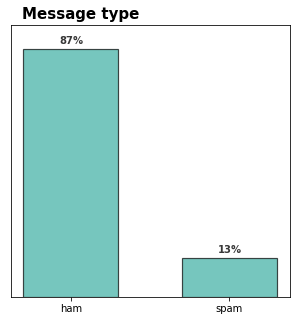

In [2]:
labels_count = sms['Label'].value_counts(normalize=True)

fig = plt.figure(figsize=(5,5))
plt.bar(labels_count.index, labels_count, alpha=0.7, width=0.6, edgecolor='black', linewidth=1.2, color='#3caea3')
plt.title('Message type', fontsize=15, fontweight='bold', position=(0.25, 1.0+0.05))
plt.yticks([])
plt.ylim(0,0.95)
for i in labels_count.index:
    plt.annotate(f"{labels_count[i]*100:.0f}%", 
                 xy=(i, labels_count[i] + 0.03),
                 va = 'center', ha='center',fontweight='bold', color='#383838'
                )
plt.show()

## Training and Test Set

We're now going to split our dataset into a training and a test set, where the training set accounts for 80% of the data, and the test set for the remaining 20%.

In [3]:
# Randomize the dataset
sms_randomized = sms.sample(frac=1, random_state=1)

# Calculate index for split
split_index = round(len(sms_randomized) * 0.8)

# Training/Test split
train = sms_randomized[:split_index].reset_index(drop=True)
test = sms_randomized[split_index:].reset_index(drop=True)

print(train.shape)
print(test.shape)

(4458, 2)
(1114, 2)


Let's check the percentage of spam and ham messages in both sets.  
They should be close to what we have in the full dataset.

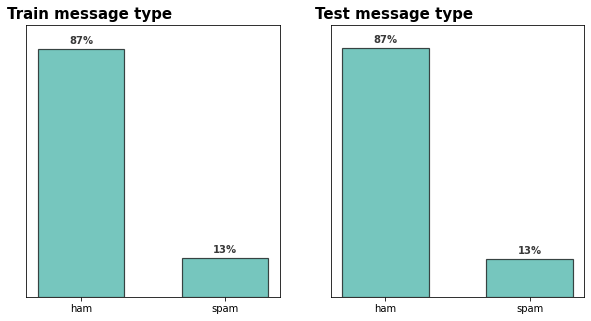

In [4]:
train_count = train['Label'].value_counts(normalize=True)
test_count = test['Label'].value_counts(normalize=True)

fig, axs  = plt.subplots(1, 2, figsize=(10,5))

for df, ax, title in zip([train_count, test_count], axs, ['Train message type', 'Test message type']):
    ax.bar(df.index, df, alpha=0.7, width=0.6, edgecolor='black', linewidth=1.2, color='#3caea3')
    ax.set_title(title, fontsize=15, fontweight='bold', position=(0.25, 1.0+0.05))
    ax.set_yticks([])
    ax.set_ylim(0,0.95)
    for i in df.index:
        ax.annotate(f"{df[i]*100:.0f}%", 
                     xy=(i, df[i] + 0.03),
                     va = 'center', ha='center',fontweight='bold', color='#383838'
                    )
plt.show()

The results look good! We'll now move on to cleaning the dataset.

## Data Cleaning

To calculate all the probabilities required by the algorithm, we'll first need to perform a bit of data cleaning to bring the data in a format that will allow us to extract easily all the information we need.

Essentially, we want to bring data to this format:

![img](https://dq-content.s3.amazonaws.com/433/cpgp_dataset_3.png)


### Letter Case and Punctuation

We'll begin with removing all the punctuation and bringing every letter to lower case.

In [5]:
# Before cleaning
train.head()

,Label,SMS
0,ham,"Yep, by the pretty sculpture"
1,ham,"Yes, princess. Are you going to make me moan?"
2,ham,Welp apparently he retired
3,ham,Havent.
4,ham,I forgot 2 ask ü all smth.. There's a card on ...


In [6]:
# After cleaning
train['SMS'] = (train['SMS']
                .str.replace('\W', ' ', regex=True)
                .str.lower())
train.head()

,Label,SMS
0,ham,yep by the pretty sculpture
1,ham,yes princess are you going to make me moan
2,ham,welp apparently he retired
3,ham,havent
4,ham,i forgot 2 ask ü all smth there s a card on ...


### The Final Training Set

In [7]:
from collections import Counter

# Split sms on words for the count
train['SMS'] = train['SMS'].str.split()

# Compute nested dictionary of word counts
# {0: {'yep': 1, 'by': 1, ...}
#  1: {'yes': 1, 'princess': 1, ...}
# }
word_dict = train['SMS'].apply(Counter).to_dict()

# Create df from nested dict
word_count = pd.DataFrame.from_dict(word_dict, orient='index')

# Outer join to retrieve empty messages
train_sms = pd.concat([train, word_count], axis=1, join='outer')

# Types dictionary 
types = {col: 'int' for col in word_count.columns}

# Fill NaN with 0s and cast int instead of float on words columns only
train_clean = (train_sms
               .fillna(0)
               .astype(types))

train_clean

,Label,SMS,yep,by,the,pretty,sculpture,yes,princess,are,...,beauty,hides,secrets,n8,jewelry,related,trade,arul,bx526,wherre
0,ham,"[yep, by, the, pretty, sculpture]",1,1,1,1,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,ham,"[yes, princess, are, you, going, to, make, me,...",0,0,0,0,0,1,1,1,...,0,0,0,0,0,0,0,0,0,0
2,ham,"[welp, apparently, he, retired]",0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,ham,[havent],0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,ham,"[i, forgot, 2, ask, ü, all, smth, there, s, a,...",0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4453,ham,"[sorry, i, ll, call, later, in, meeting, any, ...",0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,1,1,0,0
4454,ham,"[babe, i, fucking, love, you, too, you, know, ...",0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4455,spam,"[u, ve, been, selected, to, stay, in, 1, of, 2...",0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
4456,ham,"[hello, my, boytoy, geeee, i, miss, you, alrea...",0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


## Calculating Constants First

The training set being cleaned, we can now compute the algorythm. Naive Bayes, as previously mentioned is based on two probabilities:

$$
P(Spam | w_1,w_2, ..., w_n) \propto P(Spam) \cdot \prod_{i=1}^{n}P(w_i|Spam)
$$

$$
P(Ham | w_1,w_2, ..., w_n)  \propto P(Ham) \cdot \prod_{i=1}^{n}P(w_i|Ham)
$$


Also, to calculate $P(w_i|Spam)$ and $P(w_i|Ham)$ inside the formulas above, we'll need to use these equations:

$$
P(w_i|Spam) = \frac{N_{w_i|Spam} + \alpha}{N_{Spam} + \alpha \cdot N_{Vocabulary}}
$$

$$
P(w_i|Ham) = \frac{N_{w_i|Ham} + \alpha}{N_{Ham} + \alpha \cdot N_{Vocabulary}}
$$

Where $N_{set}$ is the number of words in the set.

Some of the terms in the equations above are constants. We can calculate the value of these terms once and avoid doing the computations again when a new messages comes in. Below, we'll use our training set to calculate:

- $P(Spam)$ and $P(Ham)$
- $N_{Spam}, N_{Ham}, N_{Vocabulary}$

We'll also use Laplace smoothing and set $\alpha = 1$.

In [8]:
# Isolating spam and ham messages first
spam = train_clean[train_clean['Label'] == 'spam']
ham = train_clean[train_clean['Label'] == 'ham']

# P(Spam) and P(Ham)
p_spam = len(spam) / len(train_clean)
p_ham = len(ham) / len(train_clean)

# N_spam, N_ham, N_vocabulary
n_spam = spam.sum(axis=1).sum()
n_ham = ham.sum(axis=1).sum()

# N_Vocabulary
vocabulary = list(train_clean.iloc[:,2:].columns)
n_vocabulary = len(vocabulary)

# Laplace smoothing
alpha = 1

## Calculating Parameters

We can move on with calculating the parameters $P(w_i|Spam)$ and $P(w_i|Ham)$.  
Each parameter will thus be a conditional probability value associated with each word in the vocabulary.

The parameters are calculated using the formulas:

$$
P(w_i|Spam) = \frac{N_{w_i|Spam} + \alpha}{N_{Spam} + \alpha \cdot N_{Vocabulary}}
$$

$$
P(w_i|Ham) = \frac{N_{w_i|Ham} + \alpha}{N_{Ham} + \alpha \cdot N_{Vocabulary}}
$$

In [9]:
# P(w_i|Spam)
n_words_spam = spam.sum()[2:]
p_words_spam = (n_words_spam+alpha)  / (n_spam + alpha*n_vocabulary)

#P(w_i|Ham)
n_words_ham = ham.sum()[2:]
p_words_ham = (n_words_ham+alpha)  / (n_ham + alpha*n_vocabulary)

## Classifying A New Message

Now that we have all our parameters calculated, we can start creating the spam filter. The spam filter can be understood as a function that:

- Takes in as input a new message $(w_1, w_2 ..., w_n)$.
- Clean the input according to the dataframe.
- Calculates $P(Spam|w_1, w_2, ..., w_n)$ and $P(Ham|w_1, w_2, ..., w_n)$.
- Compares the values of $P(Spam|w_1, w_2, ..., w_n)$ and $P(Ham|w_1, w_2, ..., w_n)$, and:
    - If $P(Ham|w_1, w_2, ..., w_n) > P(Spam|w_1, w_2, ..., w_n)$, then the message is classified as ham.
    - If $P(Ham|w_1, w_2, ..., w_n) < P(Spam|w_1, w_2, ..., w_n)$, then the message is classified as spam.
    - If $P(Ham|w_1, w_2, ..., w_n) = P(Spam|w_1, w_2, ..., w_n)$, then the message is not classified.

In [10]:
def naive_bayes_classifier(message, log=False):
    '''
    message: a string
    '''
    
    message = re.sub('\W', ' ', message).lower().split()
    
    p_spam_given_message = p_spam
    p_ham_given_message = p_ham

    for word in message:
        if word in p_words_spam:
            p_spam_given_message *= p_words_spam[word]
            
        if word in p_words_ham:
            p_ham_given_message *= p_words_ham[word]
    if log == True:
        print('P(Spam|message):', p_spam_given_message)
        print('P(Ham|message):', p_ham_given_message)
    
    if p_ham_given_message > p_spam_given_message:
        return 'ham'
    elif p_ham_given_message < p_spam_given_message:
        return 'spam'
    else:
        return 'unclassified'

In [11]:
naive_bayes_classifier('WINNER!! This is the secret code to unlock the money: C3421.', log=True)

P(Spam|message): 1.3481290211300841e-25
P(Ham|message): 1.9368049028589875e-27


'spam'

In [12]:
naive_bayes_classifier("Sounds good, Tom, then see u there", log=True)

P(Spam|message): 2.4372375665888117e-25
P(Ham|message): 3.687530435009238e-21


'ham'

## Measuring the Spam Filter's Accuracy

Let's see how well the filter does on our test set, which has 1,114 messages.  
We can use our classifier to create a new column in our test set according to its predictions.

In [13]:
test['predicted'] = test['SMS'].apply(naive_bayes_classifier)
test.head()

,Label,SMS,predicted
0,ham,Later i guess. I needa do mcat study too.,ham
1,ham,But i haf enuff space got like 4 mb...,ham
2,spam,Had your mobile 10 mths? Update to latest Oran...,spam
3,ham,All sounds good. Fingers . Makes it difficult ...,ham
4,ham,"All done, all handed in. Don't know if mega sh...",ham


Now, we'll write a function to measure the accuracy of our spam filter to find out how well our spam filter does.

In [14]:
test['accurate'] = test['Label'] == test['predicted']
accuracy = test['accurate'].sum()/len(test['accurate'])
accuracy

0.9874326750448833

The accuracy is close to 98.74%, which is really good. Our spam filter looked at 1,114 messages that it hasn't seen in training, and classified 1,100 correctly.

## Comparing with sklearn implementation

Several Naive Bayes algorithms are available within sklearn.  
The one we hard-coded is the [Multinomial](https://scikit-learn.org/stable/modules/naive_bayes.html#multinomial-naive-bayes) and we are going to give sklearn's one a try to compare their performance.  
We'll also leverage the Natural Language Processing library [NLTK](https://www.nltk.org) to clean our data with the following process:
- Tokenize - split the sentence in a list of words
- Remove punctuation and [stop-words](https://en.wikipedia.org/wiki/Stop_word)
- [Lemmatize](https://en.wikipedia.org/wiki/Lemmatisation) - replace words with their 'root' ("speaking" would become "speak")


In [15]:
import nltk
from nltk.tokenize import RegexpTokenizer
from nltk.corpus import stopwords
from nltk.corpus import wordnet
from nltk.stem import WordNetLemmatizer

def get_wordnet_pos(word): 
    ''' 
    Returns the context (Part-Of-Speech) for a word.
    
    Parameters:
    word (string)
    
    Returns:
    wordnet type (object)
    '''
    
    tag = nltk.pos_tag([word])
    tag_map = {
        'J': wordnet.ADJ,
        'V': wordnet.VERB,
        'N': wordnet.NOUN,
        'R': wordnet.ADV
    }
    
    return tag_map.get(tag[0][1][0], wordnet.NOUN)

def tokenize_lemmatize(sentence):
    '''
    Tokenize, clean (punctuation, stop-words) and lemmatize list of strings
    
    Parameters:
    sentence (list): list of words
    
    Returns:
    cleaned list (list)
    '''
    
    
    tokens = tokenizer.tokenize(sentence)
    return [wnl.lemmatize(word, get_wordnet_pos(word)).lower()
            for word in tokens
            if word not in stop_words
           ]

# Parameters initialization 
tokenizer = RegexpTokenizer("[\w]+")
stop_words = stopwords.words('english')
wnl = WordNetLemmatizer()

# Clean the sms
sms['SMS'] = sms['SMS'].apply(tokenize_lemmatize)

Sklearn is bundled with a tool to build the word occurence matrix: [CountVectorizer](https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.CountVectorizer.html)  
Let's use it and append the result to our dataframe. 

In [16]:
from sklearn.feature_extraction.text import CountVectorizer

vectorizer = CountVectorizer(analyzer= lambda x:x)
vector = vectorizer.fit_transform(sms['SMS'])

vocabulary_ = vectorizer.get_feature_names()
word_count_ = pd.DataFrame(vector.toarray(), columns=vocabulary_)
sms_clean = pd.concat([sms, word_count_], axis=1, join='outer')

sms_clean

,Label,SMS,0,00,000,000pes,008704050406,0089,0121,01223585236,...,zogtorius,zoom,zouk,zyada,èn,é,ú1,ü,〨ud,鈥
0,ham,"[go, jurong, point, crazy, available, bugis, n...",0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,ham,"[ok, lar, joking, wif, u, oni]",0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,spam,"[free, entry, 2, wkly, comp, win, fa, cup, fin...",0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,ham,"[u, dun, say, early, hor, u, c, already, say]",0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,ham,"[nah, i, think, go, usf, life, around, though]",0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5567,spam,"[this, 2nd, time, try, 2, contact, u, u, 750, ...",0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
5568,ham,"[will, ü, b, go, esplanade, fr, home]",0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
5569,ham,"[pity, mood, so, suggestion]",0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
5570,ham,"[the, guy, bitching, i, act, like, interested,...",0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


Finally, we can use [sklearn's algorithm](https://scikit-learn.org/stable/modules/generated/sklearn.naive_bayes.MultinomialNB.html).  
This time, we'll cross-validate our result (hence the cleaning of the entire sms dataset in the first place).

In [17]:
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import confusion_matrix

X = sms_clean.iloc[:, 2:]
y = sms_clean[['Label']].values.ravel()

mnb = MultinomialNB()
kf = KFold(n_splits=10, random_state=96121, shuffle=True)

# labels inverse the order of the matrix to comply with standards
y_pred = cross_val_predict(mnb, X, y, cv=kf)
conf_mat = confusion_matrix(y, y_pred, labels=['spam','ham'])

tp, fn, fp, tn = conf_mat.ravel()
fnr = fn / (tp+fn)
fpr = fp / (fp+tn)
acc = (tp+tn) / (tp+tn+fp+fn)

Rather than solely focusing on accuracy, we may compute the confusion matrix to better understand our algorithm efficiency.

In [18]:
conf_mat_ = pd.DataFrame(conf_mat, columns=['Spam', 'Ham'], index=['Classified spam', 'Classified ham'])
conf_mat_

,Spam,Ham
Classified spam,712,35
Classified ham,62,4763


35 were classified as spam while they were actually ham and 64 were contrarily mistaken.  
From that matrix, we can compute two extra metrics:

$ \text{Miss rate (False Negative rate)} = \frac{FN}{TP+FN} $

$ \text{Fall-Out (False Positive rate)} = \frac{FP}{FP+TN} $ 



In [19]:
scores = pd.DataFrame([acc*100, fnr*100, fpr*100], columns=['Score (%)'], index=['Accuracy', 'Miss rate', 'Fall-Out']).round(2)
scores

,Score (%)
Accuracy,98.26
Miss rate,4.69
Fall-Out,1.28


False Positives (messages classified as spam while being actual ham) are much more harmful than False Negatives.  
If we were to apply such a filter on messages sent on the network, it would mean that a fraction of texts wouldn't reach their recipients, as opposed to the miss-rate which would send actual spam to recipients.  
Yet, the accuracy of our model is great: 98.26% of all messages are correctly classified.  
Though it is lower than our implementation of Naive Bayes, it is due to the cross-validation previously used, which was skipped in the first step.

## Conclusion

In this project, we managed to build a spam filter for SMS messages using the multinomial Naive Bayes algorithm.  
Our handcrafted Naive Bayes doesn't perform badly at all compared to the one from sklearn.

Another interesting metric is the execution time.  
In order not to overload the notebook with several time execution logs, the following timings (in second) were measured separately:

|                   | Handcrafted | Sklearn |
|:------------------|-------------|---------|
| Data cleaning     | 0.1         | 45.9    |
| Word-count matrix | 36.4        | 0.6     |
| NB algorithm      | 15.6        | 13.7    |


The data-cleaning being obviously more thorough (with lemmatization) in our modern worflow, it explains the timing difference.  
The matrix calculation was suboptimal on our version and Sklearn CountVectorizer is faster by several orders of magnitude.  
Lastly, the algorithm itself is not shy compared to optimized computation of sklearn. 

The filter have an accuracy of 98.25%, which is a pretty good result. Our initial goal was an accuracy of over 90%, and we managed to do way better than that. Lowering the Fall-Out would be the next step in enhancing it.